In [53]:
import numpy as np
import rioxarray 
import xarray
import rasterio 
import rasterstats
import matplotlib.pyplot as plt
import pandas as pd
import bottleneck as bn

Saving a netCDF variable as a tif using OpenDAP with xarray and rasterio

In [10]:
#Set the opendap url
url = 'http://tethys.icimod.org:7000/thredds/dodsC/sldas/monthly/Retro.201010.nc'
#Read in the data. OpenDAP allows you to read in the data info in memory without having to download
xds = xarray.open_dataset(url)

#Take a look at the data and see what variables, dimensions, and other info that the netCDF contains 
#Notice the attributes, a lot of good information there.
xds

<xarray.Dataset>
Dimensions:            (lat: 740, lev: 3, lev_2: 4, lev_3: 4, lev_4: 4, lev_5: 3, lon: 1300, time: 1)
Coordinates:
  * lat                (lat) float64 8.025 8.075 8.125 ... 44.88 44.92 44.98
  * lev                (lev) float64 1.0 2.0 3.0
  * lev_2              (lev_2) float64 1.0 2.0 3.0 4.0
  * lev_3              (lev_3) float64 1.0 2.0 3.0 4.0
  * lev_4              (lev_4) float64 1.0 2.0 3.0 4.0
  * lev_5              (lev_5) float64 1.0 2.0 3.0
  * lon                (lon) float64 58.02 58.07 58.12 ... 122.9 122.9 123.0
  * time               (time) datetime64[ns] 2010-10-01
Data variables:
    Evap_tavg          (time, lat, lon) float32 ...
    Rainf_f_tavg       (time, lat, lon) float32 ...
    SoilMoist_inst     (time, lat, lon) float32 ...
    APAR_tavg          (time, lat, lon) float32 ...
    ActSnowNL_tavg     (time, lat, lon) float32 ...
    Albedo_inst        (time, lat, lon) float32 ...
    AvgGrndT_tavg      (time, lat, lon) float32 ...
    AvgSurfT_tavg      (time, lat, lon) float32 ...
    BareSoilT_tavg     (time, lat, lon) float32 ...
    CanopIntLiq_tavg   (time, lat, lon) float32 ...
    CanopVP_tavg       (time, lat, lon) float32 ...
    CanopWetFrac_tavg  (time, lat, lon) float32 ...
    ECanop_tavg        (time, lat, lon) float32 ...
    ESoil_tavg         (time, lat, lon) float32 ...
    EWind_f_tavg       (time, lat, lon) float32 ...
    Emiss_f_tavg       (time, lat, lon) float32 ...
    GPP_tavg           (time, lat, lon) float32 ...
    Greenness_inst     (time, lat, lon) float32 ...
    LAI_inst           (time, lat, lon) float32 ...
    LWdown_f_tavg      (time, lat, lon) float32 ...
    Lwnet_tavg         (time, lat, lon) float32 ...
    NEE_tavg           (time, lat, lon) float32 ...
    NPP_tavg           (time, lat, lon) float32 ...
    NWind_f_tavg       (time, lat, lon) float32 ...
    Psurf_f_tavg       (time, lat, lon) float32 ...
    QairT2m_tavg       (time, lat, lon) float32 ...
    Qair_f_tavg        (time, lat, lon) float32 ...
    Qg_tavg            (time, lat, lon) float32 ...
    Qh_tavg            (time, lat, lon) float32 ...
    Qle_tavg           (time, lat, lon) float32 ...
    Qs_tavg            (time, lat, lon) float32 ...
    Qsb_tavg           (time, lat, lon) float32 ...
    Qsm_tavg           (time, lat, lon) float32 ...
    RadT_tavg          (time, lat, lon) float32 ...
    SAG_tavg           (time, lat, lon) float32 ...
    SAI_inst           (time, lat, lon) float32 ...
    SAV_tavg           (time, lat, lon) float32 ...
    SWE_inst           (time, lat, lon) float32 ...
    SWdown_f_tavg      (time, lat, lon) float32 ...
    SmLiqFrac_inst     (time, lev_4, lat, lon) float32 ...
    SnowAge_tavg       (time, lat, lon) float32 ...
    SnowCover_inst     (time, lat, lon) float32 ...
    SnowDepth_inst     (time, lat, lon) float32 ...
    SnowIce_tavg       (time, lev, lat, lon) float32 ...
    SnowLiq_tavg       (time, lev_5, lat, lon) float32 ...
    SoilTemp_inst      (time, lev_3, lat, lon) float32 ...
    SwReflect_tavg     (time, lat, lon) float32 ...
    Swnet_tavg         (time, lat, lon) float32 ...
    TVeg_tavg          (time, lat, lon) float32 ...
    TWS_inst           (time, lat, lon) float32 ...
    Tair_f_tavg        (time, lat, lon) float32 ...
    Tair_f_tavg_max    (time, lat, lon) float32 ...
    Tair_f_tavg_min    (time, lat, lon) float32 ...
    TotalPrecip_tavg   (time, lat, lon) float32 ...
    VegCanopT_tavg     (time, lat, lon) float32 ...
    VegT2m_tavg        (time, lat, lon) float32 ...
    VegT_tavg          (time, lat, lon) float32 ...
    WaterTableD_inst   (time, lat, lon) float32 ...
    Wind_f_tavg        (time, lat, lon) float32 ...
    lat_2              (time, lat, lon) float32 ...
    lon_2              (time, lat, lon) float32 ...
Attributes:
    CDI:                             Climate Data Interface version ?? (http:...
    Conventions:                     CF-1.4
    institution:                     NASA 

In [12]:
#The netCDF we are looking at is the monthtly Oct avergae for 2010. 
#We can look at the Soil moisture data by calling the variable by its name
#Notice there are 3 dimensions, Time, X(lon), Y (lat) and its shape is (1,740,1300)

xds['SoilMoist_inst']

<xarray.DataArray 'SoilMoist_inst' (time: 1, lat: 740, lon: 1300)>
array([[[      nan,       nan, ..., 330.35367, 332.21674],
        [      nan,       nan, ..., 327.60724, 330.00302],
        ...,
        [145.8986 , 141.77519, ..., 170.4091 , 170.1606 ],
        [148.16905, 141.81766, ..., 175.82085, 229.82166]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 8.025 8.075 8.125 8.175 ... 44.83 44.88 44.92 44.98
  * lon      (lon) float64 58.02 58.07 58.12 58.17 ... 122.8 122.9 122.9 123.0
  * time     (time) datetime64[ns] 2010-10-01
Attributes:
    cell_methods:   lev_2: mean
    long_name:      soil moisture content
    standard_name:  soil_moisture_content
    vmax:           0.0
    vmin:           0.0
    units:          kg m2-1
    _ChunkSizes:    [   1  740 1300]

In [19]:
#If we want to get the sm values we can call its values to get an array
xds['SoilMoist_inst'].values

#Or just the 2d array
xds['SoilMoist_inst'].values[0,:,:]

array([[      nan,       nan,       nan, ..., 329.28793, 330.35367,
        332.21674],
       [      nan,       nan,       nan, ..., 323.79895, 327.60724,
        330.00302],
       [      nan,       nan,       nan, ..., 371.25452, 378.23038,
        382.71103],
       ...,
       [142.9523 , 258.4281 , 140.72842, ..., 168.80753, 196.35725,
        196.95662],
       [145.8986 , 141.77519, 142.96066, ..., 169.05165, 170.4091 ,
        170.1606 ],
       [148.16905, 141.81766, 143.10123, ..., 228.52124, 175.82085,
        229.82166]], dtype=float32)

In [16]:
#If this netCDF had a properly (proper to xarray) defined coordinate referecne system we could easily save 
#out variable as a tif and be done! It would handle the dimensions, coordinate system, etc. 

#xds['SoilMoist_inst'].rio.to_raster('SLDAS_sm_201010.tif')

#But as often happens, this is not the case. So we need to define the cordinate system


In [ ]:
#So we need to define our crs and other info so we can save out the data properly. 
#There might be a better way to to this in axarray, but I know rasterio so that's how I'm doing it

In [151]:
#In rasterio, to save an array as a GeoTiff we need to define the profile, whjioc include things such as the Affine
# dimensions, dtype, nodata, etc. All of this is availabl in the netCDF information. However, I do know that the 
#actual projection is ESPG:4326, NOT Equidistant Cylindrical, as the attibutes suggest.

#This will change for a different dataset, but it is the same for all varibles in the netCDFs from the url above.

profile = {}
profile['driver'] = 'GTiff'
profile['dtype'] = 'float32'
profile['nodata'] = -9999.0
profile['width'] = 1300
profile['height'] = 740
profile['count'] = 1
profile['crs'] = rasterio.crs.CRS.from_epsg(4326)
profile['transform'] = rasterio.Affine(0.05, 0.0, 58.0,0.0, -0.05, 45.0)
profile['tiled'] = False
profile['interleave'] = 'band'

print(profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1300, 'height': 740, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, 58.0,
       0.0, -0.05, 45.0), 'tiled': False, 'interleave': 'band'}


In [26]:
#So now we can save out a variable array to a GeoTiff using rasterio

#with rasterio.open('test5.tif', 'w', **profile) as dst: 
    #dst.write(xds['SoilMoist_inst'].values)

#One last thing to note, for some reason, the lattitude values are reversed and we need to flip them
#otherwise the tif will be upside down. The np.flip() will flip (in order) a specific axis. 
#DON'T USE THIS WITH A DIFFERENT DATASET 

with rasterio.open('SLDAS_sm_201010.tif', 'w', **profile) as dst: 
    dst.write(np.flip(xds['SoilMoist_inst'].values, axis = 1))

In [24]:
#And that's it. It would be a bit more simple if the netCDF was perfectly referenced, 
#but in my experience they rarely are. But once you define your dataset profile it's pretty straightforward
#You could create a loop of each nc file to save all the sm tifs if desired


In [27]:
# But since we have access to all the data we can do a lot of things without downloading

Aggregate over a polygon and prodce a time series

In [39]:
#Lets define a shapefile to agggregate (zonal stast) over
#Note I'm using rasterstats here. From my experience, if everyting is in ESPG:4326, things go smoothly
shp = 'Multan.shp' 


#get a list of months and years so we can produce a monlthly time series for a couple years
yrs = range(2009,2012)
mos = range(1,13)
#define a list to store our soil moisture values
sm = []  
#list of dates
dt = []
#make the magic
for yr in yrs:
    for m in mos:  
        dt.append(yr*100+m)
        url  = 'http://tethys.icimod.org:7000/thredds/dodsC/sldas/monthly/Retro.{0}{1}.nc'.format(yr,str(m).zfill(2))  
        xds = xarray.open_dataset(url)  
        #I'm getting the mean of all the pixel in the shapefile and dividing by 1000 to get sm to %
        #Also note the flip (here the ud in flipud just mean upsidedown, i.e. the axis is predefined)
        sm.append(rasterstats.zonal_stats(shp, np.flipud(xds.variables['SoilMoist_inst'][0,:].values), stats = 'mean', 
                                          affine = profile['transform'], nodata = -9999.0)[0]['mean']/1000)  
        
#This will take a few minutes, probably 

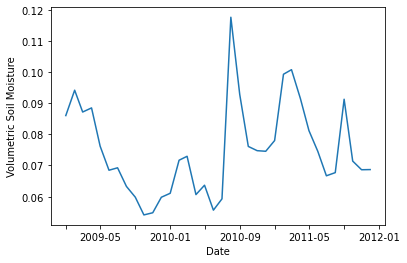

In [60]:
#Simple plot of the data *** ALWAYS GOOD TO LOOK AT YOUR DATA ***
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(dt, format = '%Y%m'), sm)
ax.set_ylabel('Volumetric Soil Moisture')
ax.set_xlabel('Date')
#quick way to make a cleaner x-axis 
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

#Or save it out to a csv for later
#pd.DataFrame(sm, index = pd.to_datetime(dt, format = '%Y%m'), columns = ['Soil Moisture']).to_csv('PlotEx.csv')

Getting summary stats or anomalies using openDAP and xarray

In [129]:
#What if we looped through all the dates to get our summary statistics?
#First lets get set all the array that we will need to get an anomaly
#All the data in one array shape = #yrs*#mos, 740,1300
BigArray = np.zeros((192,740,1300))
#An array that will hold all the years for a given month so we can calculate the stastistics shape = #yrs, 730, 1300
yrarray = np.zeros((16,740,1300))
#Monthly means shape = #mos, 740,1300
moarrayM = np.zeros((12,740,1300))
#Monthly st deviations shape = #mos, 740,1300
moarrayS = np.zeros((12,740,1300))


#set list is years and months to loop through 
mos = range(1,13)
yrs = range(2004,2020)

#list to keep track of the BigArray axis 0
dt = []

for mx, m in enumerate(mos):
    for yx, yr in enumerate(yrs):
        dt.append(yx+(16*mx))
        url  = 'http://tethys.icimod.org:7000/thredds/dodsC/sldas/monthly/Retro.{0}{1}.nc'.format(yr,str(m).zfill(2))
        data = xarray.open_dataset(url)['SoilMoist_inst'].values[0,:,:]/1000
        BigArray[yx+(16*mx),:,:] = data
        yrarray[yx,:,:] = data
    #supposedly bottleneck (bn) is much faster then np.mean, especially when nans are involved
    moarrayM[mx,:,:] = bn.nanmean(yrarray, axis = 0)
    moarrayS[mx,:,:] = bn.nanstd(yrarray, axis = 0)
    #Print statement to know it's working...it takes a while
    print('Finished all the years for Month {}'.format(m))
    #sys.exit()
        

        

Finished all the years for Month 1
Finished all the years for Month 2
Finished all the years for Month 3
Finished all the years for Month 4
Finished all the years for Month 5
Finished all the years for Month 6
Finished all the years for Month 7
Finished all the years for Month 8
Finished all the years for Month 9
Finished all the years for Month 10
Finished all the years for Month 11
Finished all the years for Month 12


In [153]:
#Now we have all the information that we need in three arrays: BigArray, moarrayM, moarrayS
#so we can loop though the data in BigArray (note the index list of dt will help us know what's what)

for ix in range(BigArray.shape[0]):
    yr = dt[ix][0]
    mo = dt[ix][1]
    #Actual month data
    data = BigArray[ix,:,:]
    #Calcualte anomaly from mean and std. dev
    anom = (data-moarrayM[mo-1,:,:])/moarrayS[mo-1,:,:]
    
    with rasterio.open('anom/SLDAS_smAnom_{0}{1}.tif'.format(yr,mo), 'w', **profile) as dst:
        #once again using the flip here, remember its not needed on othe datasets
        #when the stats are computed the dtype is converted to 64 bit so we cast the array as float32 to match the profile
        dst.write(np.flip(np.expand_dims(anom.astype('float32'), axis=0),axis = 1))
    #sys.exit()

<ipython-input-153-f3df0a706cd7>:9: RuntimeWarning: invalid value encountered in true_divide
  anom = (data-moarrayM[mo-1,:,:])/moarrayS[mo-1,:,:]
